# Diagrams for projections

Run the notebook with the linear projections. In doing so, you will have generated a bunch of numpy array files, which you can load into this notebook to do the final plots which go into the report.

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import seaborn as sns
import torch

pd.options.display.max_colwidth = 100

In [3]:
from coma.utils.decomposition import (
    PCAShapeModel3D,
    KPCAShapeModel3D,
    GraphSpectralFiltering,
    LDA
)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [30]:
meshes = torch.load('training_meshes.pt')
features = pd.read_csv('training_metadata.csv')
val_meshes = torch.load('validation_meshes.pt')
val_features = pd.read_csv('validation_metadata.csv')

print(meshes.shape)
print(features.shape)
print(val_meshes.shape)
print(val_features.shape)
val_features.head()

(10441, 642, 3)
(10441, 6)
(1160, 642, 3)
(1160, 6)


,Unnamed: 0,eid,sex,age,structure_volume,brain_volume
0,11193,4758894,0,65,20880,976696
1,10524,4859976,1,65,25429,1273450
2,2263,3035091,0,49,24303,1079650
3,6313,1199825,1,52,24295,1263650
4,11960,3191856,1,54,23293,1316450


In [31]:
features.replace({'sex': {0: 'F', 1: 'M'}}, inplace=True)
val_features.replace({'sex': {0: 'F', 1: 'M'}}, inplace=True)
val_features.head()

,Unnamed: 0,eid,sex,age,structure_volume,brain_volume
0,11193,4758894,F,65,20880,976696
1,10524,4859976,M,65,25429,1273450
2,2263,3035091,F,49,24303,1079650
3,6313,1199825,M,52,24295,1263650
4,11960,3191856,M,54,23293,1316450


In [7]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]

In [8]:
# plot_mesh(meshes[0], faces, figsize=(20, 10), elevations=[45], azimuths=3)

In [9]:
def lda_2d_proj_vis(lda_proj, classes, ax=None, title=''):
    """
    lda_proj: (N, 2)
    classes: (N, ) or (N, 1)
    """
    if ax is not None:
        ax.set_title(title)
    else:
        plt.title(title)
    
    data = np.concatenate([lda_proj, classes.reshape(-1, 1)], axis=1)
    data_df = pd.DataFrame(data, columns=['x1', 'x2', 'classes'])
    
    kwargs = {
        'data': data_df,
        'x': 'x1', 'y': 'x2',
        'hue': 'classes',
        'palette': 'muted',
    }
    if ax is not None:
        kwargs['ax'] = ax
        
    sns.scatterplot(**kwargs)

In [10]:
def plot(a, b, c, features, n, filename, size='brain vol.', hue='struct vol.', style=None, **kwargs):
    data = np.concatenate([
        a, b, c
    ], axis=1)
    data_df = pd.DataFrame(data, columns=['x11', 'x12', 'x21', 'x22', 'x31', 'x32'])
    data_df = pd.concat([
        data_df,
        features[['sex', 'age', 'brain_volume', 'structure_volume']],
    ], axis=1)
    data_df.rename(columns={'brain_volume': 'brain vol.', 'structure_volume': 'struct vol.'}, inplace=True)
    data_df = data_df.sample(n=n)

    width = 16
    height = width / (1.618 * 2)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
    ax = sns.scatterplot(
        data=data_df,
        x='x11', y='x12',
        size=size,
        hue=hue,
        style=style,
        ax=axes[0],
        # sizes=(5, 50),
        **kwargs,
    )
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis='y', direction='in')
    ax.tick_params(axis='x', direction='in')
    ax.get_legend().remove()

    ax = sns.scatterplot(
        data=data_df,
        x='x21', y='x22',
        size=size,
        hue=hue,
        style=style,
        ax=axes[1],
        # sizes=(5, 50),
        **kwargs,
    )
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis='y', direction='in')
    ax.tick_params(axis='x', direction='in')
    ax.get_legend().remove()

    ax = sns.scatterplot(
        data=data_df,
        x='x31', y='x32',
        size=size,
        hue=hue,
        style=style,
        ax=axes[2],
        # sizes=(5, 50),
        **kwargs,
    )
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis='y', direction='in')
    ax.tick_params(axis='x', direction='in')
    ax.legend(bbox_to_anchor=(1.01, 1))

    sns.despine()
    fig.tight_layout()
    plt.savefig(f'{filename}.png', dpi=300)
    plt.show()

In [11]:
def preprocess(features):
    print(features.shape)
    bins = 5
    structure_vol_range = features.structure_volume.max() - features.structure_volume.min()
    bin_width = np.ceil(structure_vol_range / bins)
    structure_vol_class = (features.structure_volume - features.structure_volume.min()) // bin_width
    structure_vol_class.name = 'structure_volume_class'
    
    brain_vol_range = features.brain_volume.max() - features.brain_volume.min()
    bin_width = np.ceil(brain_vol_range / bins)
    brain_vol_class = (features.brain_volume - features.brain_volume.min()) // bin_width
    brain_vol_class.name = 'brain_volume_class'

    features_list = [features, structure_vol_class, brain_vol_class]
    features_with_classes = pd.concat(features_list, axis=1)

    pair_classes = features_with_classes[['structure_volume_class', 'brain_volume_class']].values.tolist()
    multi_classes = {}
    # Main difference between this and DeepSCM, is that we are assuming
    #  each (Data, class) pair is IID. We don't consider any dependencies.
    classes = []
    i = 0
    for pair in pair_classes:
        pair = tuple(pair)
        if pair in multi_classes:
            classes.append(multi_classes[pair])
        else:
            classes.append(i)
            multi_classes[pair] = i
            i += 1

    classes = np.array(classes)
    
    return classes

In [12]:
classes = preprocess(features)
val_classes = preprocess(val_features)

(10441, 6)
(1160, 6)


In [13]:
proj_dim = 10

### PCA + LDA

In [14]:
pca = PCAShapeModel3D()
pca.fit(meshes)
pca_proj = pca.project(meshes, dim=proj_dim)
val_pca_proj = pca.project(val_meshes, dim=proj_dim)

In [15]:
lda = LDA()
lda.fit(pca_proj, classes)
lda_proj = lda.project(pca_proj, dim=2)
val_lda_proj = lda.project(val_pca_proj, dim=2)

### KPCA + LDA

In [16]:
kpca = KPCAShapeModel3D(kernel_type='rbf', max_comps=proj_dim)
kpca.fit(meshes)
kpca_proj = kpca.project(meshes, dim=proj_dim)
val_kpca_proj = kpca.project(val_meshes, dim=proj_dim)

In [17]:
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components=60, kernel='rbf')
# kpca.fit(meshes.reshape(meshes.shape[0], -1))
# kpca_proj = kpca.transform(meshes.reshape(meshes.shape[0], -1))
# val_kpca_proj = kpca.transform(val_meshes.reshape(val_meshes.shape[0], -1))

In [18]:
lda = LDA()
lda.fit(kpca_proj, classes)
lda_kpca_proj = lda.project(kpca_proj, dim=2)
val_lda_kpca_proj = lda.project(val_kpca_proj, dim=2)

### Spectral Embedding + KPCA + LDA

In [19]:
spectral_filter = GraphSpectralFiltering(meshes.shape[1], 'sym_scaled')
spectral_filter.fit(faces)

modes = 20

spec_proj = np.zeros_like(meshes)
for i in range(meshes.shape[0]):
    spec_proj[i] = -spectral_filter.project(meshes[i], dim=modes)
    
val_spec_proj = np.zeros_like(val_meshes)
for i in range(val_meshes.shape[0]):
    val_spec_proj[i] = -spectral_filter.project(val_meshes[i], dim=modes)

In [20]:
kpca = KPCAShapeModel3D(kernel_type='rbf', max_comps=proj_dim)
kpca.fit(spec_proj.reshape(spec_proj.shape[0], -1))
spec_kpca_proj = kpca.project(spec_proj.reshape(spec_proj.shape[0], -1), dim=proj_dim)
val_spec_kpca_proj = kpca.project(val_spec_proj.reshape(val_spec_proj.shape[0], -1), dim=proj_dim)
# kpca = KPCAShapeModel3D(kernel='rbf', max_comps=60)
# kpca.fit(meshes)
# kpca_proj = kpca.project(meshes, dim=60)
# val_kpca_proj = kpca.project(val_meshes, dim=60)

In [21]:
lda = LDA()
lda.fit(spec_kpca_proj, classes)
lda_spec_kpca_proj = lda.project(spec_kpca_proj, dim=2)
val_lda_spec_kpca_proj = lda.project(val_spec_kpca_proj, dim=2)

### Plots

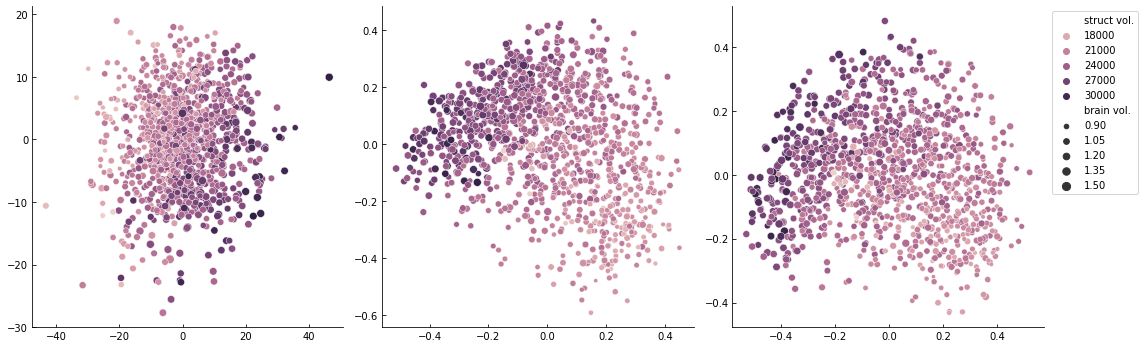

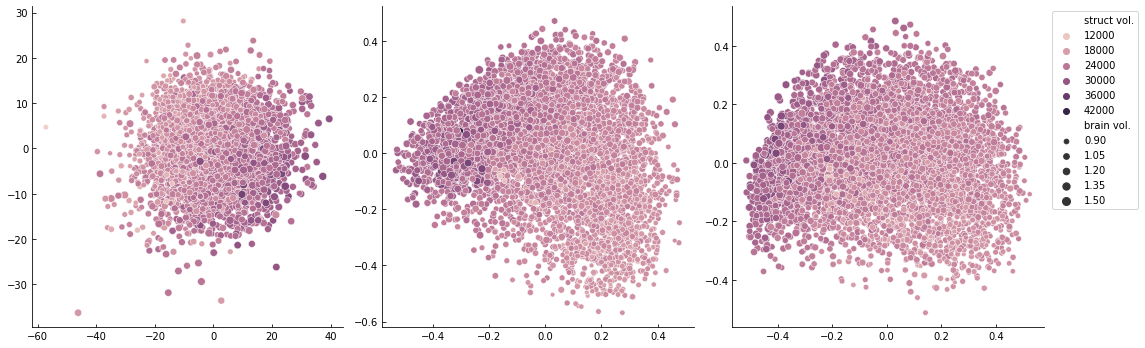

In [27]:
plot(
    val_lda_proj,
    val_lda_kpca_proj,
    val_lda_spec_kpca_proj,
    val_features,
    n=val_lda_proj.shape[0],
    filename='validation_projections'
)
plot(
    lda_proj,
    lda_kpca_proj,
    lda_spec_kpca_proj,
    features,
    n=5000,
    filename='training_projections'
)

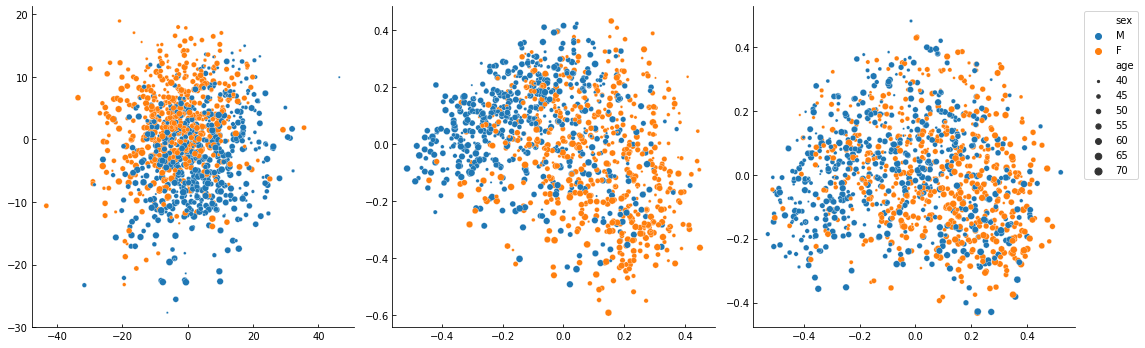

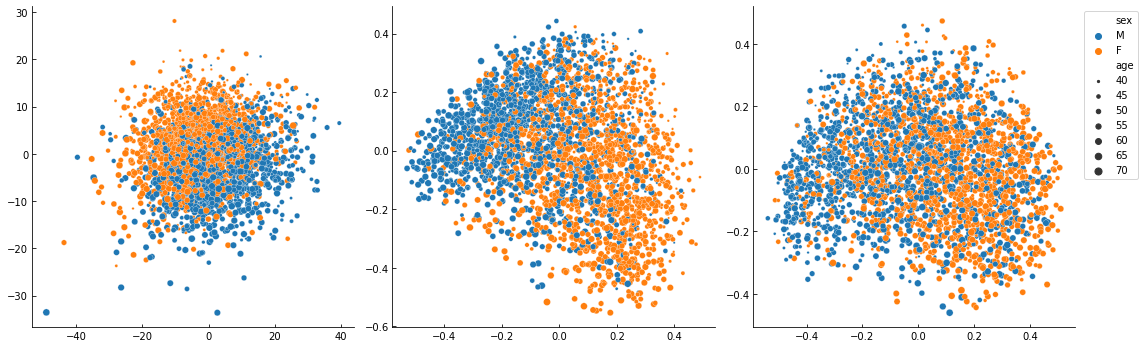

In [32]:
plot(
    val_lda_proj,
    val_lda_kpca_proj,
    val_lda_spec_kpca_proj,
    val_features,
    n=val_lda_proj.shape[0],
    filename='validation_projections_age_sex',
    hue='sex', style=None, size='age',
    sizes=(5, 50),
)
plot(
    lda_proj,
    lda_kpca_proj,
    lda_spec_kpca_proj,
    features,
    n=3000,
    filename='training_projections_age_sex',
    hue='sex', style=None, size='age',
    sizes=(5, 50),
)